In [1]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir write

'wget' is not recognized as an internal or external command,
operable program or batch file.
The system cannot find the path specified.


In [ ]:
print("hi")

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc


In [4]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.2 anndata==0.8.0 umap==0.5.3 numpy==1.21.5 scipy==1.9.1 pandas==1.4.4 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.8


In [5]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results

In [6]:
adata = sc.read_10x_mtx(
    'C:/Users/nusup/Downloads/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

In [7]:
adata.var_names_make_unique()  

In [8]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [9]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

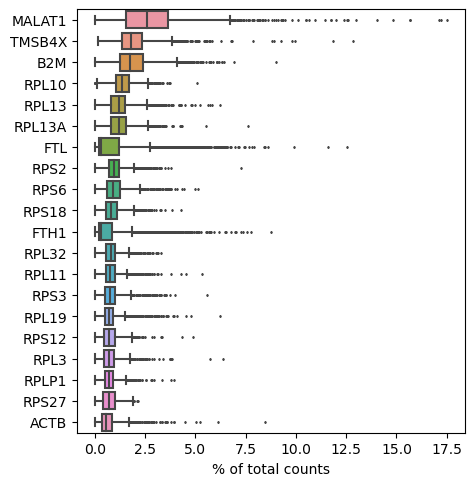

In [10]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [12]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [13]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

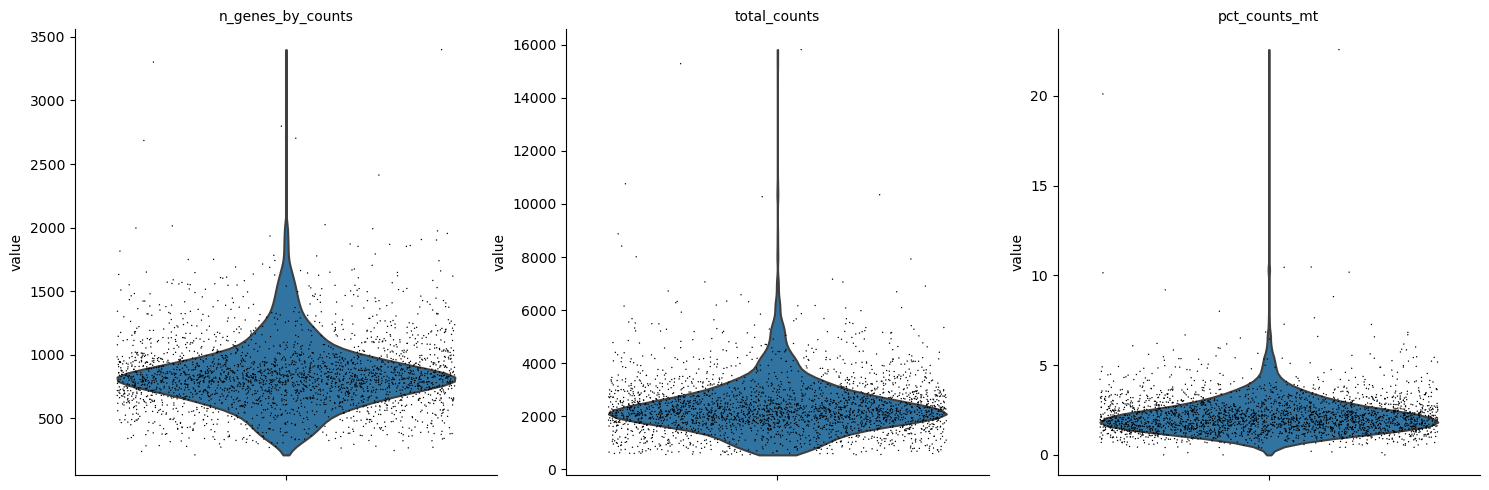

In [15]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

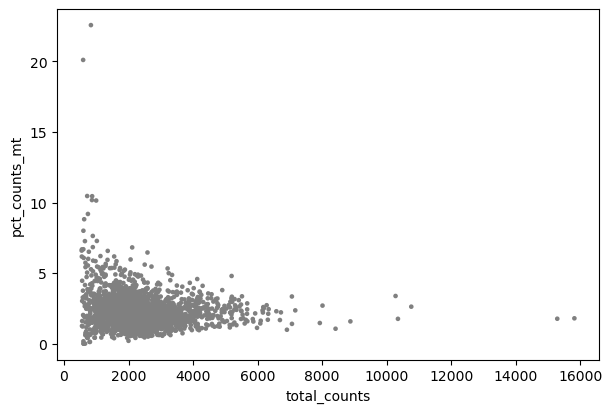

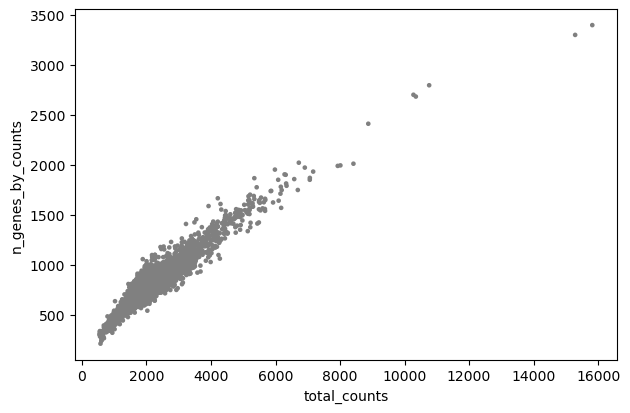

In [16]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')


In [17]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [22]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [23]:
sc.pp.log1p(adata)

In [26]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

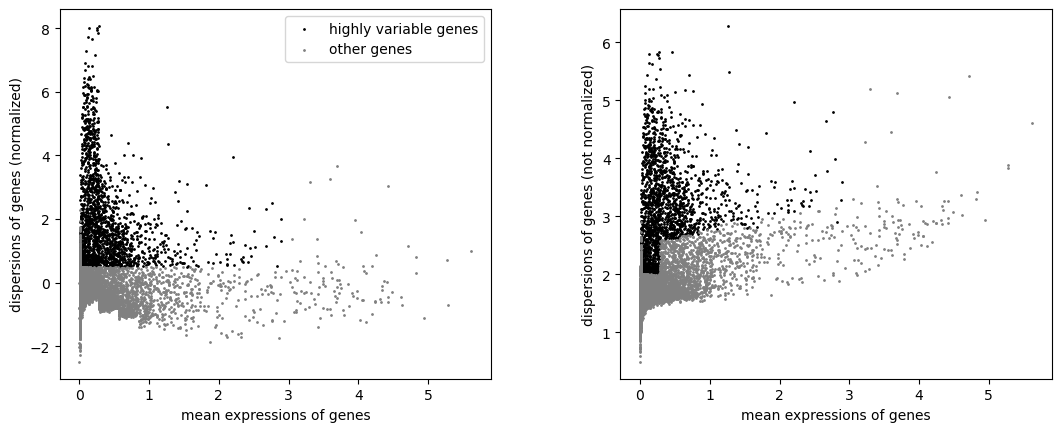

In [27]:
sc.pl.highly_variable_genes(adata)

In [28]:
adata.raw = adata

In [29]:
adata = adata[:, adata.var.highly_variable]

In [30]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [31]:
sc.tl.pca(adata, svd_solver='arpack')

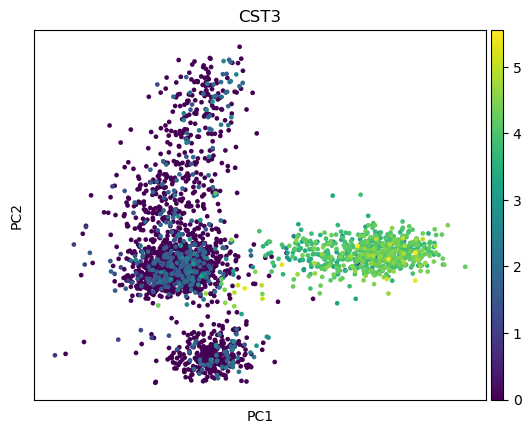

In [33]:
sc.pl.pca(adata, color='CST3')

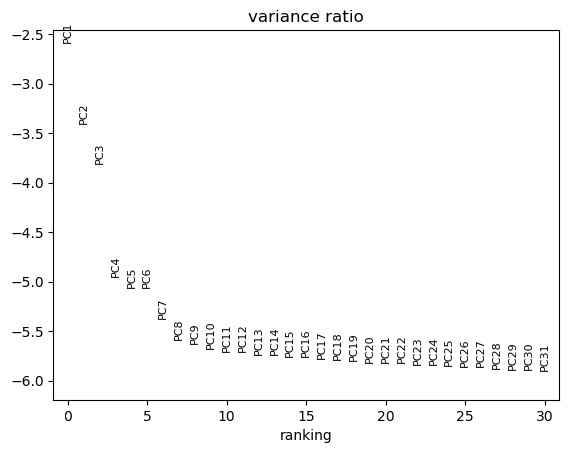

In [34]:
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
adata.write(results_file)

In [37]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [40]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [ ]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)
sc.tl.umap(adata, init_pos='paga')

In [43]:
sc.tl.umap(adata)

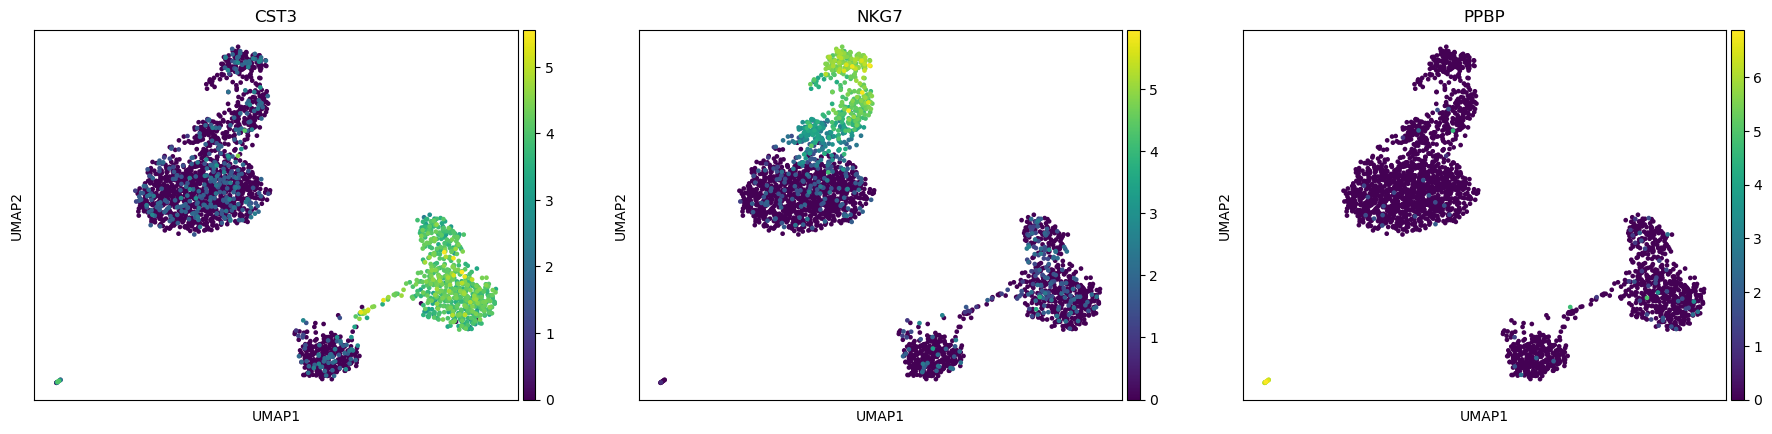

In [44]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

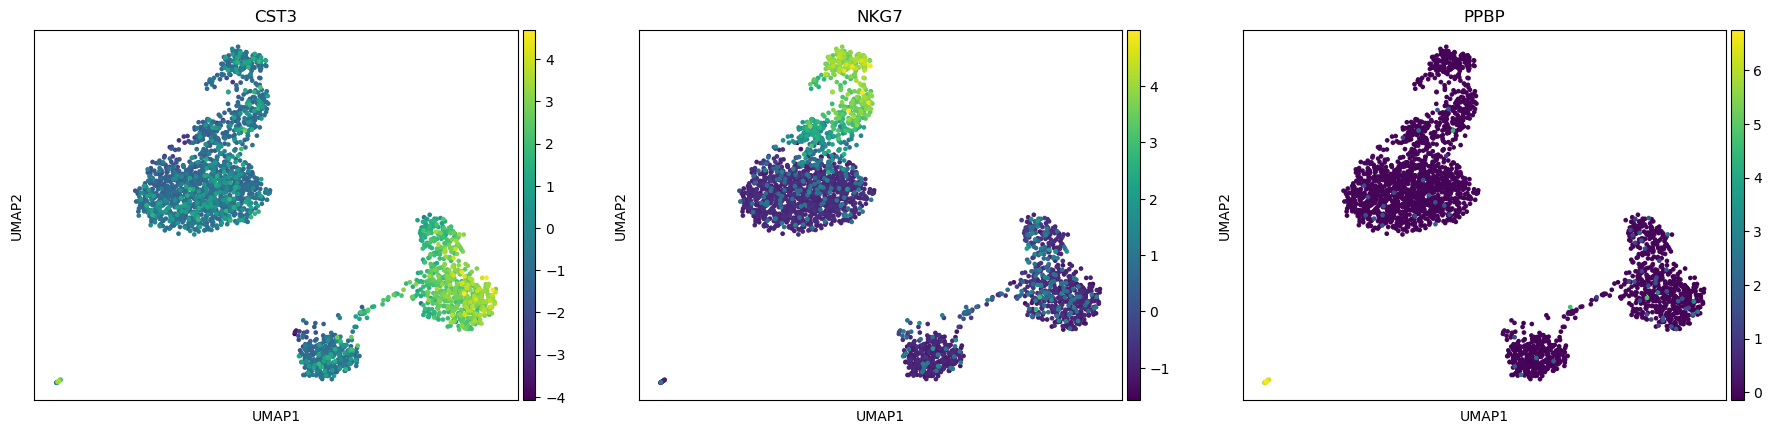

In [45]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

In [46]:
sc.tl.leiden(adata)

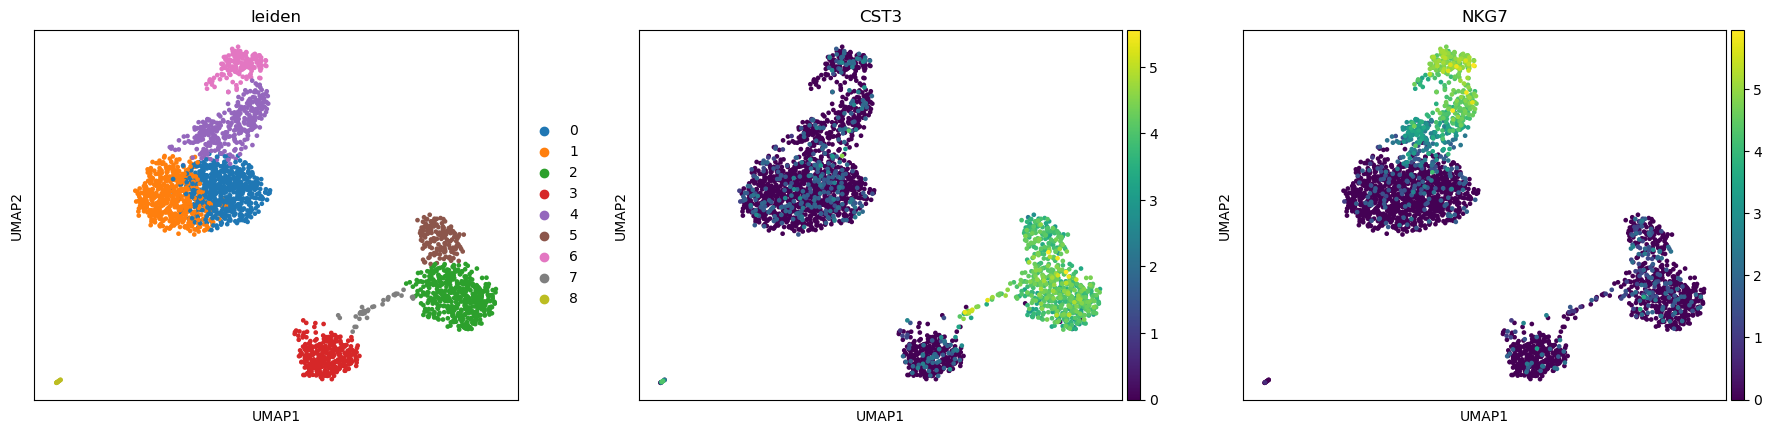

In [47]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [ ]:
adata.write(results_file)

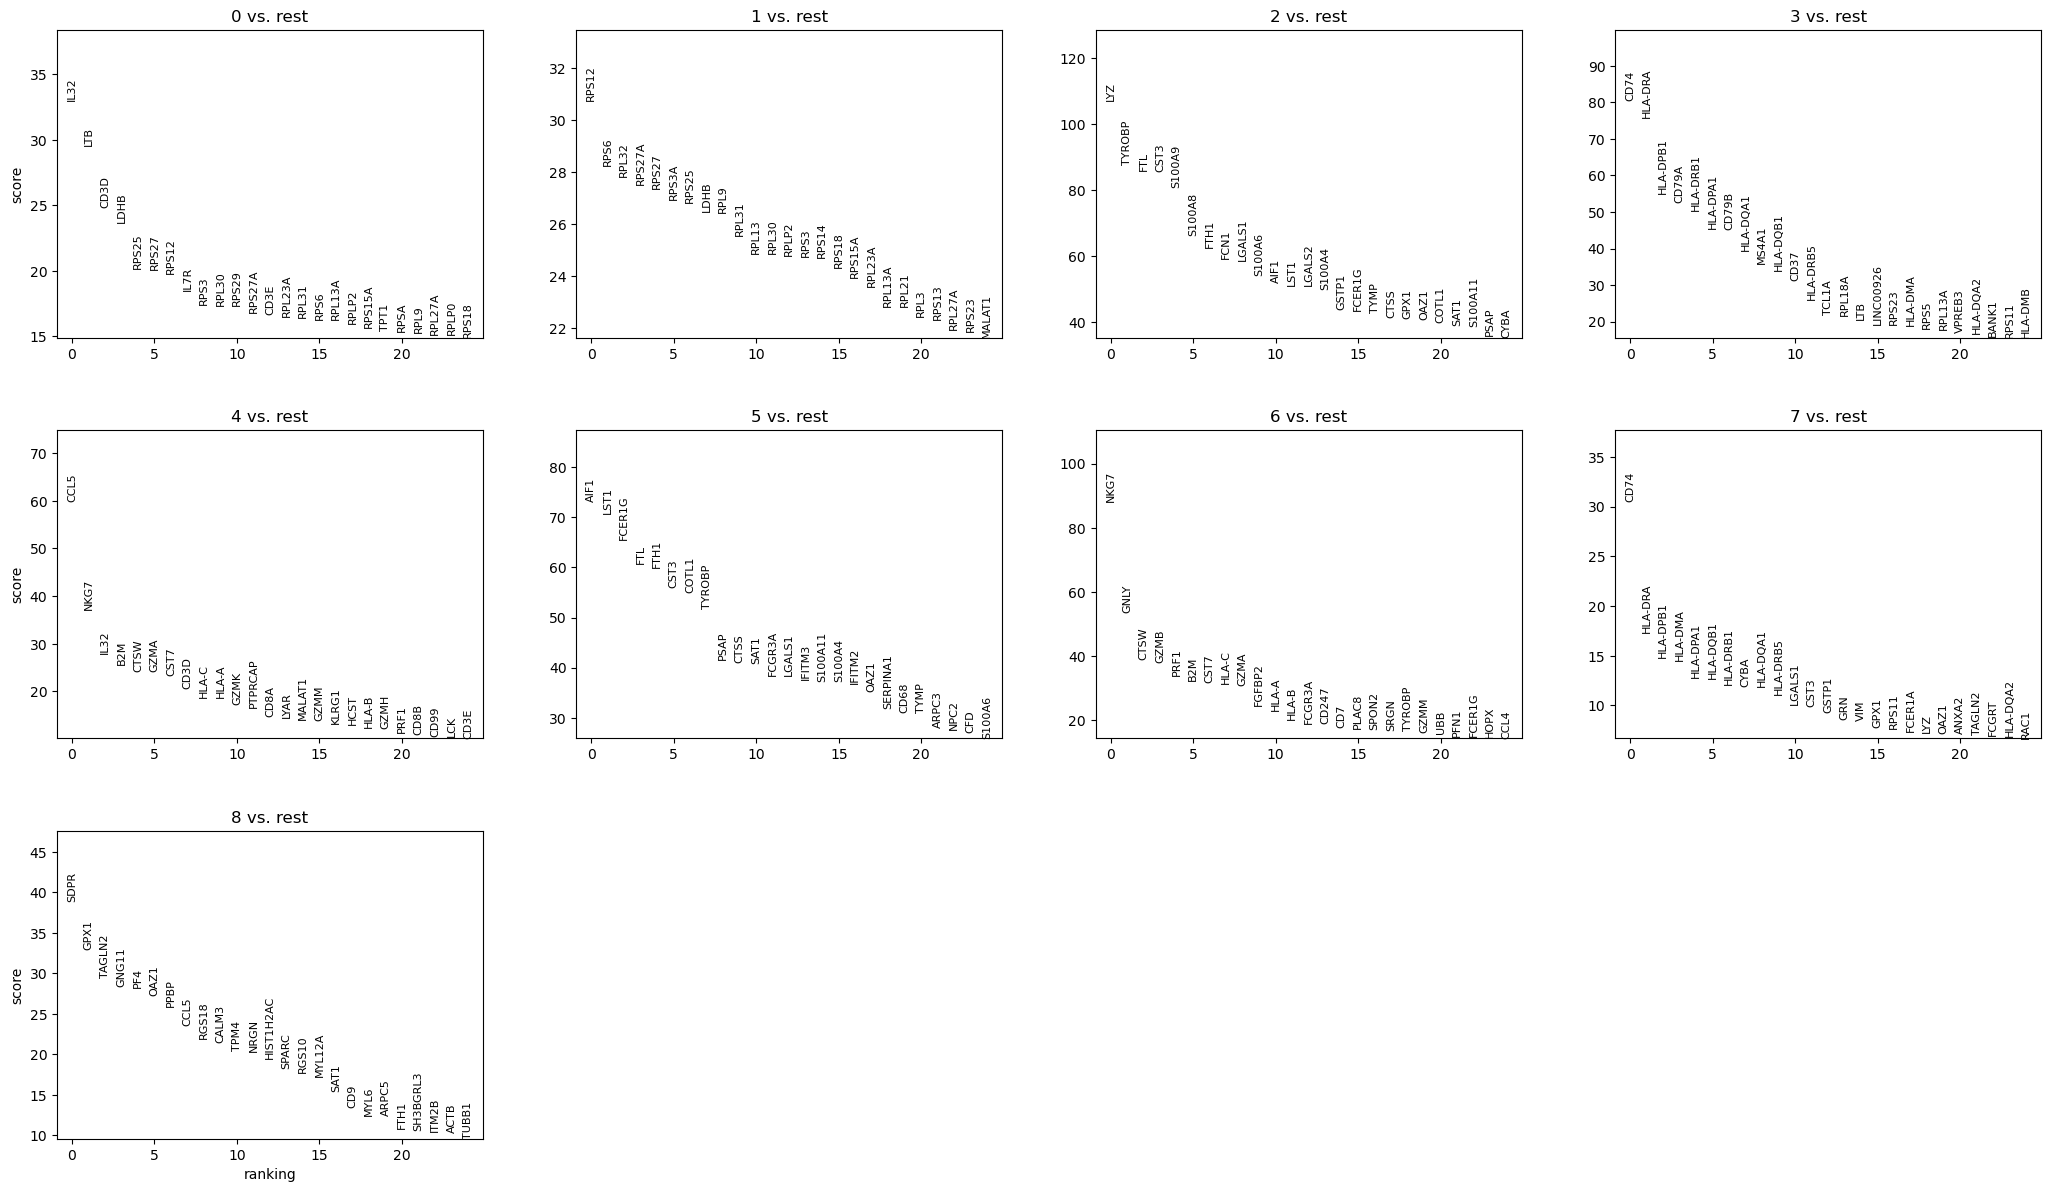

In [49]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [50]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:05)


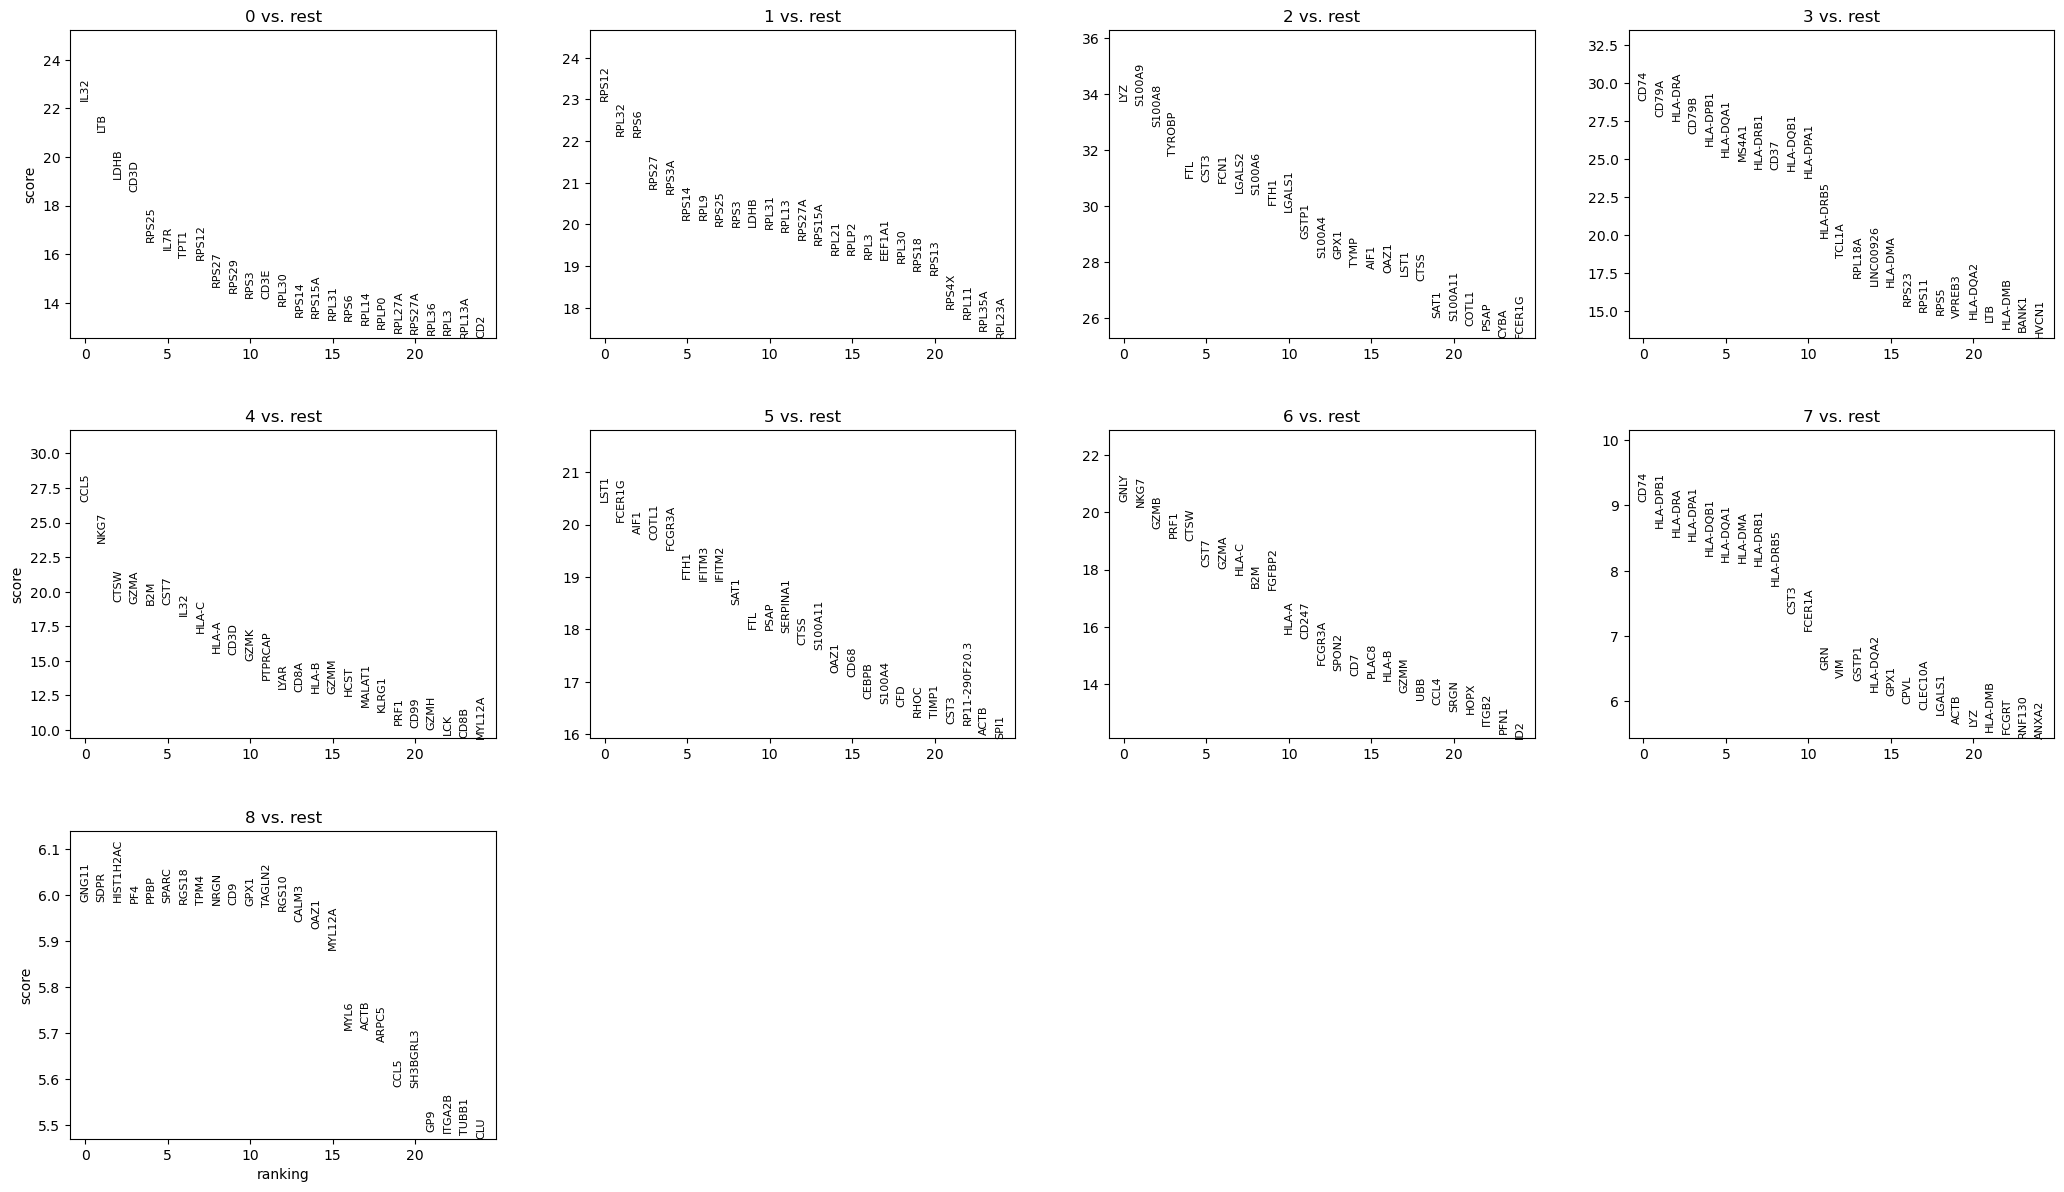

In [51]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
adata.write(results_file)

ranking genes
    finished (0:00:08)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


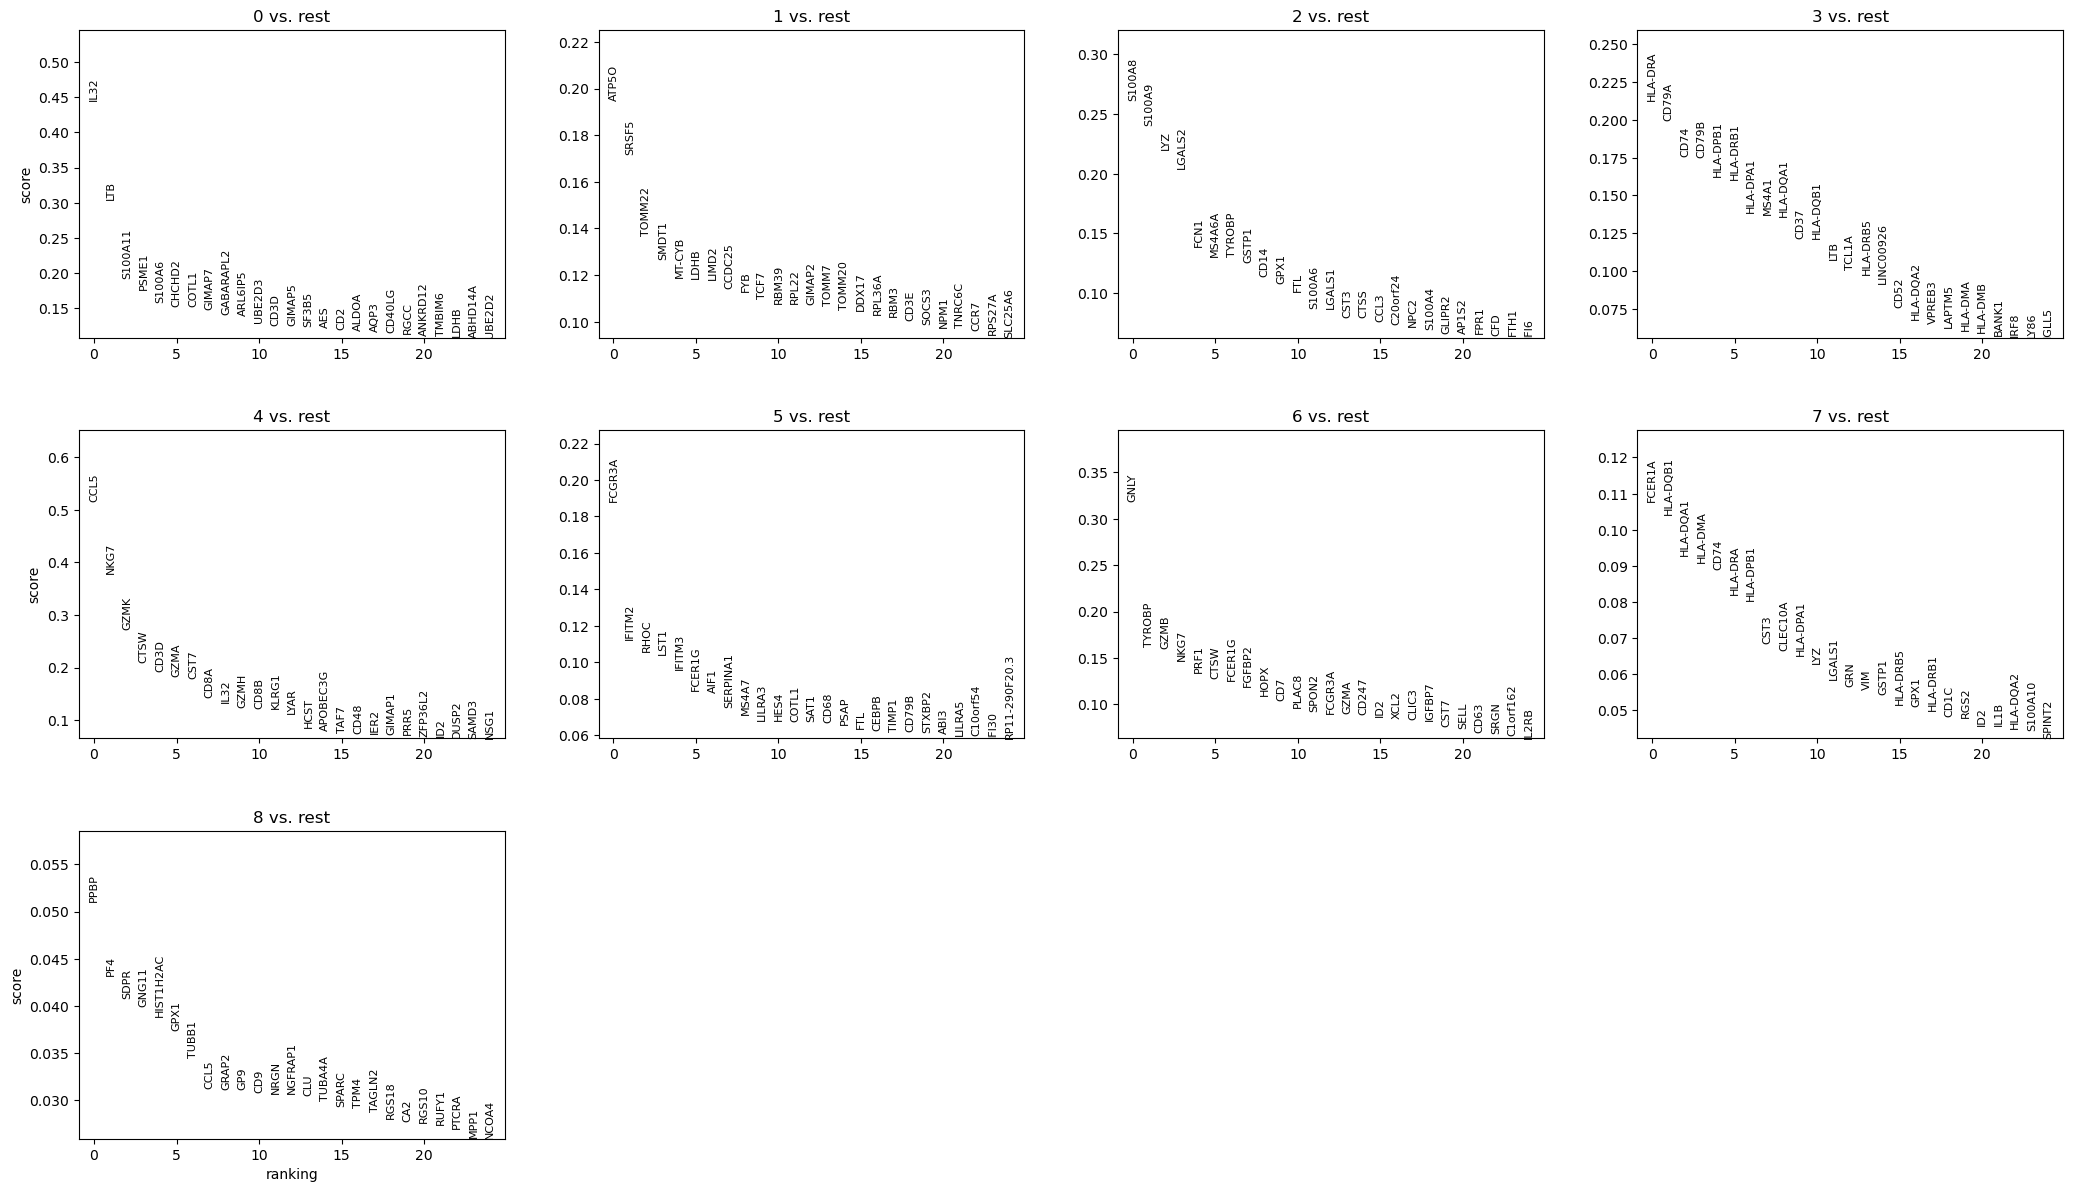

In [53]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [54]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [ ]:
adata = sc.read(results_file)

In [55]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8
0,IL32,ATP5O,S100A8,HLA-DRA,CCL5,FCGR3A,GNLY,FCER1A,PPBP
1,LTB,SRSF5,S100A9,CD79A,NKG7,IFITM2,TYROBP,HLA-DQB1,PF4
2,S100A11,TOMM22,LYZ,CD74,GZMK,RHOC,GZMB,HLA-DQA1,SDPR
3,PSME1,SMDT1,LGALS2,CD79B,CTSW,LST1,NKG7,HLA-DMA,GNG11
4,S100A6,MT-CYB,FCN1,HLA-DPB1,CD3D,IFITM3,PRF1,CD74,HIST1H2AC


In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)


ranking genes
    finished (0:00:01)


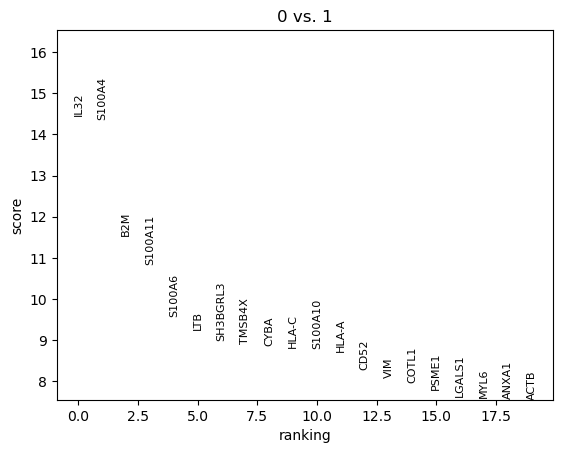

In [61]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

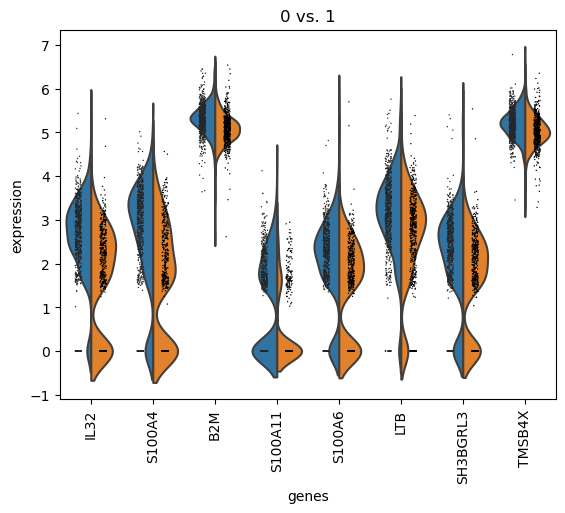

In [62]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [ ]:
adata = sc.read(results_file)

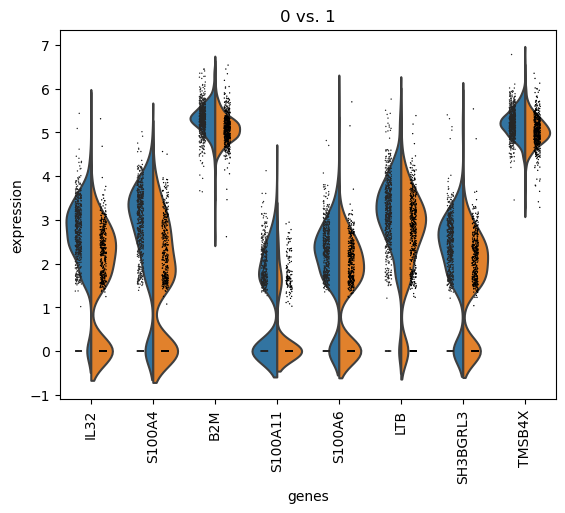

In [64]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

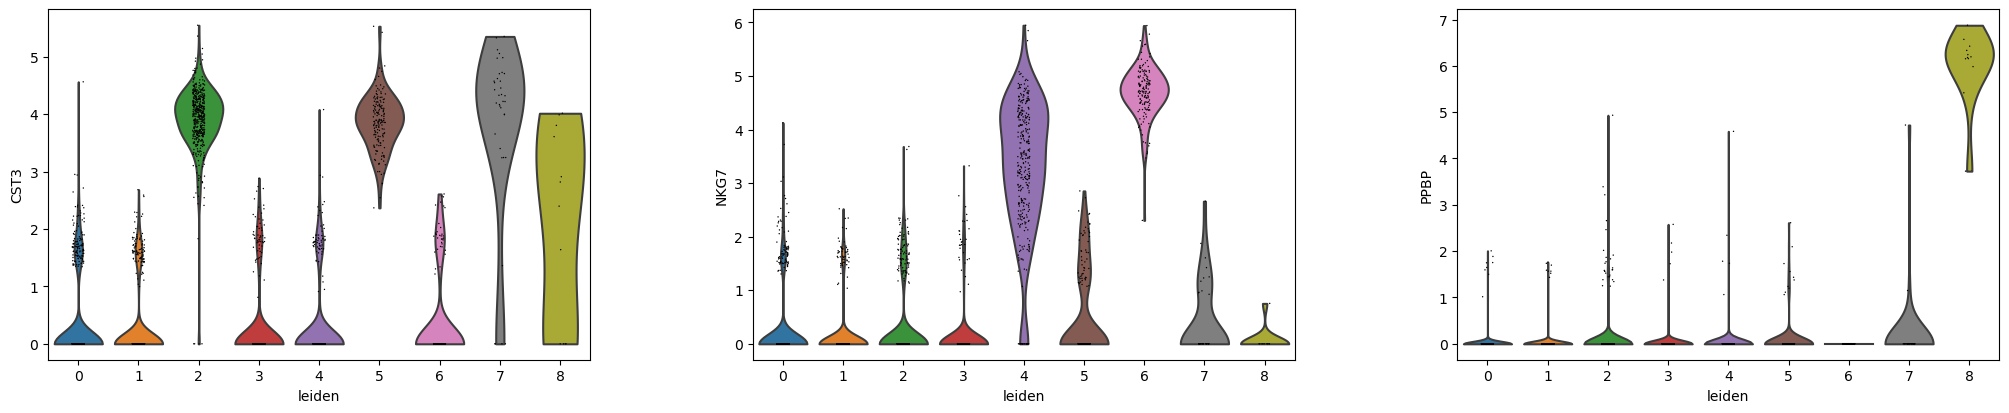

In [65]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

In [ ]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

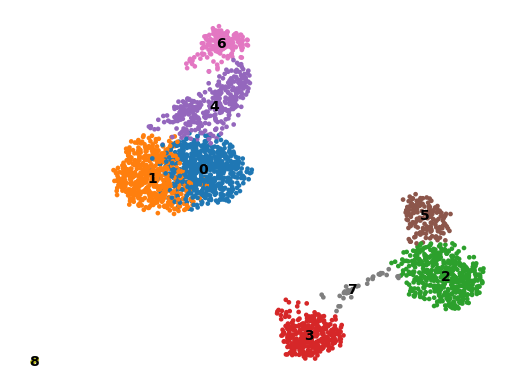

In [67]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

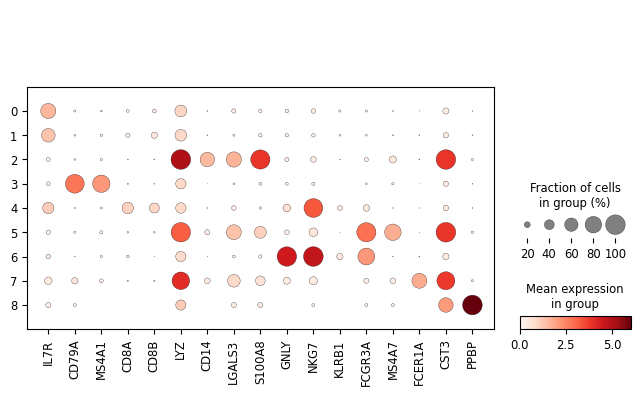

In [68]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden')

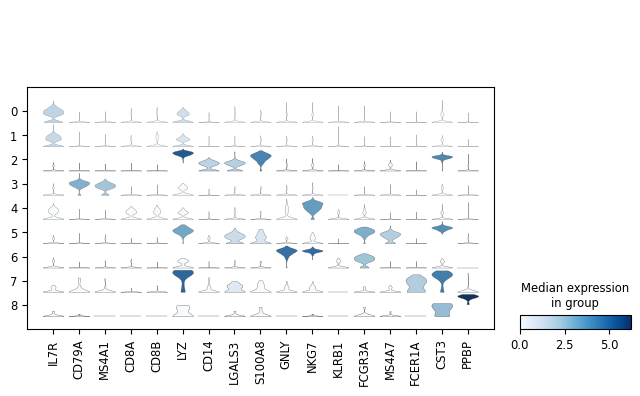

In [69]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

In [70]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
adata.write(results_file, compression='gzip') 

In [72]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')

In [73]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )